<h1 style='text-align: center;'> BlackJack Simulation through lens of Monte Carlo </h1>

## Introduction

Black jack can be modelled using reinforcement learning as it can solve tasks without having any prior knowledge. Learning happens based on the feedback obtained from its own actions and experiences.Since, the major goal behind this study is find ways for the player to beat the house, we are going to take a monte carlo approach of RL. This contains two parts - 

1. Predicting the value of current hand and dealer's showing card using First Visit monte carlo algorithm
2. Determing optimal strategies using Constant-alpha First  Visit algorithm 

We begin the simulation by importing the relevant packages. The path in the command sys.path.append() depends upon the path of gym package installation. 

## Importing packages

In [16]:
import sys
sys.path.append('c:/users/asoum/anaconda3/lib/site-packages')   #library path to gym package

import random
from random import shuffle
import os
import gym
import numpy as np
import pandas as pd
from matplotlib import pyplot
from IPython.display import HTML
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.axes3d import get_test_data
from collections import defaultdict
from functools import partial
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.axes_grid1 import make_axes_locatable

env = gym.make('Blackjack-v1') #Creating environment for storing the states, values and rewards


# To center all the plots in the notebook
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

###### Note: 
If 'Blackjack-v1' throws error in gym.make() method, then change it as 'Blackjack-v0'

## Monte Carlo Prediction

## Policy and Game definitions

Monte carlo prediction entails estimation of value function for a given policy which is done by sampling a bunch of episodes based on the pre-determined policy. In our case, th epolicy is, if the value exceeds 17 then the player opts to stand. 

In [17]:
def policies(observation):     #If score of hand dealt is less than 17  hit or else stand
    player_score, dealer_score, usable_ace = observation
    return 0 if player_score >= 17 else 1    #0-Stand and 1-Hit

def game(policy, env): #Simulate a game
    
    states, actions, rewards = [], [], []
    observation = env.reset()  #Initialising environment
    
    while True:
        states.append(observation) #Append state information
        action = policy(observation) 
        actions.append(action) #Append action information
        observation, reward, done, info = env.step(action)
        rewards.append(reward) #Append reward information
        
        # Break if the state is a terminal state (i.e. done)
        if done:
             break
                
    return states, actions, rewards

## Prediction logic

In [18]:
def mc_prediction(policy, env, n_episodes):
    
    value_table = defaultdict(float) #Table to store values of each state
    N = defaultdict(int)

    
    for _ in range(n_episodes):
    
        states, _, rewards = game(policy, env) #For each iteration store state and reward information
        returns = 0
        
        for t in range(len(states) - 1, -1, -1):  
            R = rewards[t]  #Rewards
            S = states[t]   #States         
            returns += R
            
            if S not in states[:t]:       #Check if the episode is visited for first time
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S]
    
    return value_table
 
value = mc_prediction(policies, env, n_episodes=500000)


for i in range(10):
  print(value.popitem())

((12, 9, True), -0.0701754385964912)
((15, 8, True), -0.0500927643784787)
((5, 9, False), -0.2527716186252773)
((4, 3, False), -0.17699115044247782)
((5, 5, False), -0.17401392111368905)
((13, 3, True), 0.08593750000000006)
((18, 7, True), 0.37685459940652843)
((4, 4, False), -0.2276785714285713)
((17, 3, True), -0.11275964391691394)
((13, 2, True), 0.04458598726114651)


The state obtained is a 3-tuple with players sum, dealer’s sum and if there exists a usable ace. An ace is considered usable when the existence of ace does not lead to a bust. 0 indicates action stick. 

## Plot the results

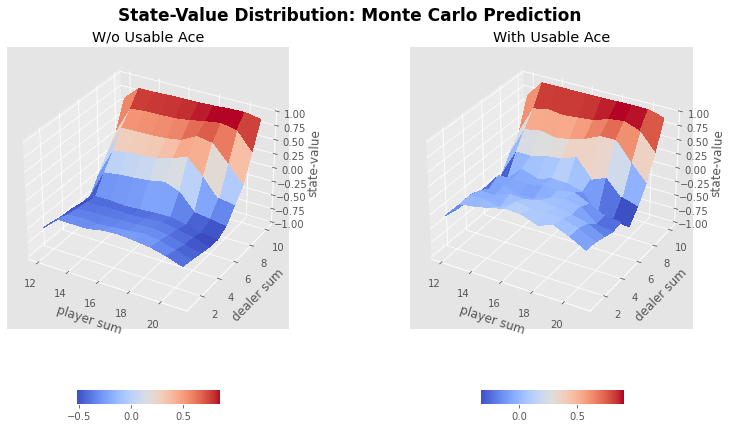

In [19]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

# plot a 3D surface
player_sum = np.arange(12, 21 + 1)
dealer_sum = np.arange(1, 10 + 1)
usable_ace = np.array([False, True])
state_values = np.zeros((len(player_sum), len(dealer_sum), len(usable_ace)))

for i, player in enumerate(player_sum):
    for j, dealer in enumerate(dealer_sum):
        for k, ace in enumerate(usable_ace):
            state_values[i, j, k] = value[player, dealer, ace]

X, Y = np.meshgrid(player_sum, dealer_sum)
Z = state_values[:, :, 0]
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)
ax.set_ylabel('dealer sum')
ax.set_xlabel('player sum')
ax.set_zlabel('state-value')
ax.set_title('W/o Usable Ace')
fig.colorbar(surf, shrink=0.5, aspect=10,location='bottom')

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

Z = state_values[:, :, 1]
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)
ax.set_ylabel('dealer sum')
ax.set_xlabel('player sum')
ax.set_zlabel('state-value')
ax.set_title('With Usable Ace')
fig.colorbar(surf, shrink=0.5, aspect=10,location='bottom')

# ==============
# Overall plot 
# ==============

fig.suptitle('State-Value Distribution: Monte Carlo Prediction',fontweight ="bold",fontsize = 17)
fig.set_size_inches(12, 7)
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

###### Observation:
From the 3D plot of state value distribution we can see that, in both the cases, the state values are higher, when the player sum is around 20 or 21, and dealer sum is around 10. This is obvious because we are most likely to win the game. 

## Optimal Solution for BlackJack

Alternating between policy evaluation which is the Q value below and policy improvement obtained based on constant-alpha first vist algorithm that follows epsilon-greedy method which is the output of ops method, will result in possible optimal solutions. 

In [20]:
def probs(nQ, epsilon, acts):
    """ 
    Get the probability of taking the best known action according to epsilon.
    Returns the policy for the Q value given
    """
    
    npolicy = np.ones(acts) * epsilon / acts
    nacts = np.argmax(nQ)
    if(nacts == 2):
        nacts = 1
    npolicy[nacts] = 1 - epsilon + (epsilon / acts)
    return npolicy



def npolicy(Q,acts):
    return dict((k,np.argmax(j)) for k,j in Q.items())




def newQ(env, episode, Q, alpha, gamma):
    """
    Calculate the new Q values for the actions taken in the given episode.
    Returns the new Q policy
    """
    
    for i, j, k in episode:
        frst_occur = next(l for l,x in enumerate(episode) if x[0] == i)
        G = sum([x[2]*(gamma**l) for l,x in enumerate(episode[frst_occur:])])
        Q[i][j] = Q[i][j] + alpha*(G - Q[i][j])
    
    return Q  

In [21]:
def games(env, Q, epsilon, acts):
    
    episode = []
    state = env.reset()
    while True:
        prob = probs(Q[state], epsilon, acts)
        
        action = np.random.choice(np.arange(acts), p=prob) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode 



def ops(env,epis):
        
        epsilon = 1.0
        eps_min = 0.01
        decay = 0.9999
        alpha = 0.001
        gamma = 1.0
        
        acts = env.action_space.n
        Q = defaultdict(lambda: np.zeros(epis))
        for i_epis in range(1, epis+1):
            if i_epis % 1000 == 0:
                #print("\rEpisode {}/{}.".format(i_epis, epis), end="")
                sys.stdout.flush()
        
            epislon = max(epsilon*decay, eps_min)
            episode = games(env, Q, epsilon, acts)
            Q = newQ(env, episode, Q, alpha, gamma)
    
        policy = npolicy(Q, acts)
        return policy, Q


policy, Q = ops(env, 500000)
output = dict((k,np.max(j)) for k, j in Q.items())
for i in range(10):
  print(output.popitem())

((5, 7, False), 0.0)
((4, 1, False), 0.0)
((12, 5, True), 0.0)
((12, 4, True), 0.0)
((14, 3, True), 0.0)
((4, 9, False), 0.0)
((19, 3, True), 0.10269780847179107)
((12, 6, True), 0.0)
((6, 4, False), 0.0)
((20, 5, True), 0.15873721212129369)


The state obtained is a 3-tuple with players sum, dealer’s sum and if there exists a usable ace. An ace is considered usable when the existence of ace does not lead to a bust. 0 indicates action stick. 

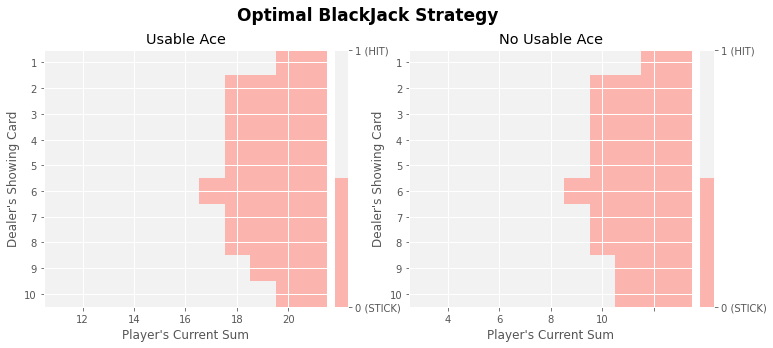

In [42]:
def plot_usable_ace(policy):

    def calculate_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[calculate_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel1', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        if usable_ace:
            x_range = np.arange(11, 22)
            y_range = np.arange(10, 0, -1)
        else:
            x_range = np.arange(1,11)
            y_range = np.arange(10, 0, -1)
            labels = [item.get_text() for item in ax.get_xticklabels()]
            labels = np.arange(2, 12, 2)
            ax.set_xticklabels(labels)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
    
    
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    fig.suptitle('Optimal BlackJack Strategy', fontweight ="bold",fontsize = 17)
    plt.show()


plot_usable_ace(policy)

###### Observation:
From the plot above we can see that, the grey areas are hit and highlighted areas are stick. Despite the scope improvement for No usable Ace, we can see that for Usable ace the strategy is very good. In most of the cases, hit seems to be the strategy.  